In [21]:
 # -*- coding: UTF-8 -*-  
import random
import copy
import numpy as np
import time
from matplotlib import pyplot as plt
import torch
from matplotlib.patches import Circle
import geopandas as gpd
import numpy as np
import pandas as pd

### Population distribution

In [22]:
poi = gpd.read_file("./population.shp")

In [23]:
poi['easting'] = poi.geometry.x
poi['northing'] = poi.geometry.y
value_field = 'NUMPOINTS'
total_pop = sum(poi[value_field])
print("The number of records is ", len(poi))
print("The total population are ", total_pop)

The number of records is  4732
The total population are  2856936.0


### Existing sound sensors

In [24]:
site_nodes=gpd.read_file("./sound nodes.shp")
site_nodes['POINT_X'] = site_nodes.geometry.x
site_nodes['POINT_Y'] = site_nodes.geometry.y
sites = np.array(site_nodes[['POINT_X', 'POINT_Y']], dtype=np.float64)
print("The number of sound nodes in Chicago is ", sites.shape[0])

The number of sound nodes in Chicago is  35


## Genetic Algorithm

In [25]:
class Chromosome:
    """
    Class Chromosome represents one chromosome which consists of genetic code and value of
    fitness function.
    Genetic code represents potential solution to problem - the list of locations that are selected
    as medians.
    """

    def __init__(self, content, fitness):
        self.content = content
        self.fitness = fitness

    def __str__(self): return "%s f=%d" % (self.content, self.fitness)

    def __repr__(self): return "%s f=%d" % (self.content, self.fitness)

In [26]:
class GeneticAlgorithm:

    def __init__(self, n, m, e, p, cost_matrix, all_dist, r, setup_cost, demand):

        self.time = None
        # self.num_facilities = num_facilities
        # Number of demand points
        self.user_num = n
        # Number of potential deployment point of sound sensors
        self.fac_num = m
        # 35 sound sensors already available
        self.exist_fac_num = e
        # Number of sound sensors to be deployed
        self.p = p
        # Radius of sound sensor monitoring
        self.r = r
        self.cost_matrix = cost_matrix
        self.all_dist = all_dist
        # Setting weight for each part of the objective function
        self.setup_cost = setup_cost
        # weight
        self.demand = demand
        self.iterations = 1200  # Maximal number of iterations
        self.current_iteration = 0
        self.generation_size = 30  # Number of individuals in one generation
        self.reproduction_size = 10  # Number of individuals for reproduction

        self.mutation_prob = 0.3  # Mutation probability

        self.top_chromosome = None  # Chromosome that represents solution of optimization process

    def mutation(self, chromosome):
        """
        Applies mutation over chromosome with probability self.mutation_prob
        In this process, a randomly selected median is replaced with a randomly selected demand point.
        """

        mp = random.random()
        if mp < self.mutation_prob:
            # index of randomly selected median:
            i = random.randint(0, len(chromosome) - 1)
            # demand points without current medians:
            demand_points = [element for element in range(0, len(self.cost_matrix)) if element not in chromosome]
            # replace selected median with randomly selected demand point:
            chromosome[i] = random.choice(demand_points)

        return chromosome

    def crossover(self, parent1, parent2):

        identical_elements = [element for element in parent1 if element in parent2]

        # If the two parents are equal to each other, one of the parents is reproduced unaltered for the next generation
        # and the other parent is deleted, to avoid that duplicate individuals be inserted into the population.
        if len(identical_elements) == len(parent1):
            return parent1, None

        exchange_vector_for_parent1 = [element for element in parent1 if element not in identical_elements]
        exchange_vector_for_parent2 = [element for element in parent2 if element not in identical_elements]

        c = random.randint(0, len(exchange_vector_for_parent1) - 1)

        for i in range(c):
            exchange_vector_for_parent1[i], exchange_vector_for_parent2[i] = exchange_vector_for_parent2[i], \
                                                                             exchange_vector_for_parent1[i]

        child1 = identical_elements + exchange_vector_for_parent1
        child2 = identical_elements + exchange_vector_for_parent2

        return child1, child2

    def fitness(self, chromosome):
        """ Calculates fitness of given chromosome """
        exist_fac_list = [self.fac_num + i for i in range(self.exist_fac_num)]
        chromosome = chromosome + exist_fac_list
        # print("-------------",chromosome)
        dist_p = self.all_dist[chromosome]
        mask = dist_p < self.r
        dist_p[mask] = 1
        dist_p[~mask] = 0
        backup_cover = np.sum(dist_p, axis=0)

        cover_1 = [1 if x == 1 else 0 for x in backup_cover]
        cover_2 = [1 if y >= 2 else 0 for y in backup_cover]
        count_1 = np.sum(cover_1 * self.demand)
        count_2 = np.sum(cover_2 * self.demand)

        no_cover_1 = np.sum(self.demand) - count_1
        no_cover_2 = np.sum(self.demand) - count_2

        no_cover = self.setup_cost[0] * no_cover_1 + self.setup_cost[1] * no_cover_2
        return no_cover

    def initial_random_population(self):
        """
        Creates initial population by generating self.generation_size random individuals.
        Each individual is created by randomly choosing p facilities to be medians.
        """

        init_population = []
        for k in range(self.generation_size):
            rand_medians = []
            facilities = list(range(self.fac_num))
            for i in range(self.p):
                rand_median = random.choice(facilities)
                rand_medians.append(rand_median)
                facilities.remove(rand_median)
            init_population.append(rand_medians)

        init_population = [Chromosome(content, self.fitness(content)) for content in init_population]
        self.top_chromosome = min(init_population, key=lambda chromo: chromo.fitness)
        print("Current top solution: %s" % self.top_chromosome)
        return init_population

    def selection(self, chromosomes):
        """Ranking-based selection method"""

        # Chromosomes are sorted ascending by their fitness value
        chromosomes.sort(key=lambda x: x.fitness)
        L = self.reproduction_size
        selected_chromosomes = []

        for i in range(self.reproduction_size):
            j = L - np.floor((-1 + np.sqrt(1 + 4 * random.uniform(0, 1) * (L ** 2 + L))) / 2)
            selected_chromosomes.append(chromosomes[int(j)])
        return selected_chromosomes

    def create_generation(self, for_reproduction):
        """
        Creates new generation from individuals that are chosen for reproduction,
        by applying crossover and mutation operators.
        Size of the new generation is same as the size of previous.
        """
        new_generation = []

        while len(new_generation) < self.generation_size:
            parents = random.sample(for_reproduction, 2)
            child1, child2 = self.crossover(parents[0].content, parents[1].content)

            self.mutation(child1)
            new_generation.append(Chromosome(child1, self.fitness(child1)))

            if child2 is not None and len(new_generation) < self.generation_size:
                self.mutation(child2)
                new_generation.append(Chromosome(child2, self.fitness(child2)))

        return new_generation

    def optimize(self):

        start_time = time.time()

        chromosomes = self.initial_random_population()

        while self.current_iteration < self.iterations:
            # From current population choose individuals for reproduction
            for_reproduction = self.selection(chromosomes)

            # Create new generation from individuals that are chosen for reproduction
            chromosomes = self.create_generation(for_reproduction)

            self.current_iteration += 1

            chromosome_with_min_fitness = min(chromosomes, key=lambda chromo: chromo.fitness)
            if chromosome_with_min_fitness.fitness < self.top_chromosome.fitness:
                self.top_chromosome = chromosome_with_min_fitness

        end_time = time.time()
        self.time = end_time - start_time
        hours, rem = divmod(end_time - start_time, 3600)
        minutes, seconds = divmod(rem, 60)

        print()
        print("Final top solution: %s" % self.top_chromosome)
        print('Time: {:0>2}:{:0>2}:{:05.4f}'.format(int(hours), int(minutes), seconds))
        


### Visualization of the output data

In [27]:
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])
    
    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]  
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit, 
            s=unit, horizontalalignment='left',
            verticalalignment='center')

In [28]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [29]:
def display_points_with_bclp(poi, facilities, exist_fac, centers, radius):
    sitedf1 = site_nodes[site_nodes['POINT_X'] < max(poi['easting'])]
    sitedf1 = sitedf1[sitedf1['POINT_X'] > min(poi['easting'])]
    sitedf1 = sitedf1[sitedf1['POINT_Y'] < max(poi['northing'])]
    sitedf1 = sitedf1[sitedf1['POINT_Y'] > min(poi['northing'])] 
    ax = plt.gca()
    poi.plot(ax = ax, column=poi[value_field], scheme = 'natural_breaks', k=8, markersize=20, cmap='Blues', label='Population')
    for i in centers:
        plt.scatter(facilities[i][0], facilities[i][1], c='SlateBlue', s=100, marker='+')
        circle = Circle(xy=(facilities[i][0], facilities[i][1]), radius=radius, color='SlateBlue', fill=False, lw=2)
        ax.add_artist(circle)
    for j in range(len(exist_fac)):
        plt.scatter(exist_fac[j][0], exist_fac[j][1], c='Salmon', s=100, marker='+')
        circle = Circle(xy=(exist_fac[j][0], exist_fac[j][1]), radius=radius, color='Salmon', fill=False, lw=2)
        ax.add_artist(circle)
    plt.scatter(facilities[i][0], facilities[i][1], c='SlateBlue', marker='+', s=60, label='Optimized Sound Sensors')
    plt.scatter(exist_fac[j][0], exist_fac[j][1], c='Salmon', marker='+', s=60, label='Current Sound Sensors')
    
    render_scale_bar(ax = ax, x=0.05, y=0.05)
    render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)

 

### calculate

Current top solution: [1882, 1069, 1405, 3605, 1641, 3320, 1796, 1346, 2984, 3216] f=2501020

Final top solution: [3228, 3643, 3321, 3644, 2630, 2736, 3573, 3408, 3490, 3640] f=2069554
Time: 00:02:13.7501
Covered once points: [ 797  798  799  810  811  812  850  851  852  853  863  864  865  866
  901  902  903  914  915  916  917  952  965  966  973  974 1026 1027
 1028 1029 1080 1081 1082 1083 1137 1138 1139 2021 2022 2115 2116 2117
 2119 2120 2210 2211 2212 2213 2214 2215 2216 2309 2310 2311 2312 2313
 2314 2315 2325 2326 2327 2416 2417 2418 2428 2429 2430 2431 2525 2526
 2527 2532 2536 2543 2544 2552 2553 2559 2632 2633 2636 2640 2641 2646
 2647 2648 2649 2655 2656 2657 2658 2662 2663 2664 2682 2683 2684 2685
 2690 2691 2692 2693 2737 2740 2741 2743 2744 2745 2750 2751 2752 2753
 2759 2760 2761 2762 2766 2767 2768 2769 2785 2786 2787 2789 2790 2794
 2795 2796 2797 2835 2836 2839 2842 2843 2845 2846 2853 2854 2862 2863
 2864 2868 2869 2871 2872 2887 2888 2891 2892 2896 2897 2898 289

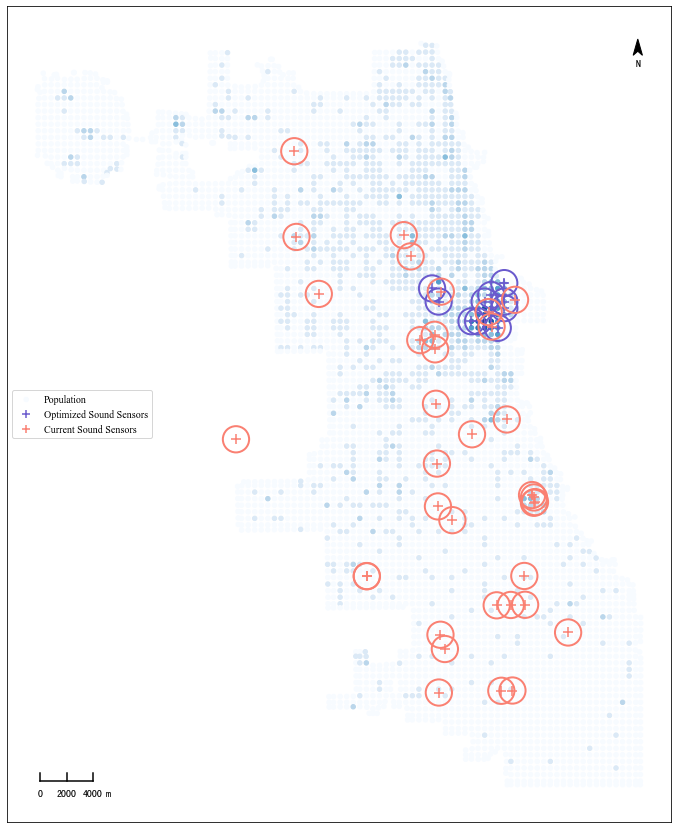

In [30]:
if __name__ == '__main__':
    data = poi[['easting', 'northing']]
    sensors = site_nodes[['POINT_X','POINT_Y']]
    # num_located = int(poi.shape[0]/5)
    # Setting seeds for specific GPUs
    torch.manual_seed(1234)
    # Setting the monitoring radius
    radius = 1000
    # Setting the demand points
    n_users = poi.shape[0]
    # Setting the potential deployment point of sound sensors
    n_facilities = poi.shape[0]
    # Setting the existing sound sensors
    n_exist_fac = site_nodes.shape[0]
    # print(n_exist_fac)
    # Number of sound sensors to be deployed
    n_centers = 10
    # Setting weight for each part of the objective
    setup_cost = [0.0,1.0]
    
    # weight
    demand = poi[value_field]

    users = [(data['easting'][i], data['northing'][i]) for i in range(n_users)]
    
    facilities = [(data['easting'][i], data['northing'][i]) for i in range(n_facilities)]
    exist_fac = [(sensors['POINT_X'][i], sensors['POINT_Y'][i]) for i in range(n_exist_fac)]
    users, facilities, exist_fac = np.array(users), np.array(facilities), np.array(exist_fac) # Convert to a two-dimensional array
    all_facilities = np.vstack((facilities, exist_fac))
#     print("=======")
#     print(all_facilities)
    # print(all_facilities.shape)

    # Calculating Euclidean distances
    distance = np.sum((facilities[:, np.newaxis, :] - users[np.newaxis, :, :]) ** 2, axis=-1) ** 0.5 # 50*50
    all_dist = np.sum((all_facilities[:, np.newaxis, :] - users[np.newaxis, :, :]) ** 2, axis=-1) ** 0.5
    
    start_time = time.time()
    
    genetic = GeneticAlgorithm(n_users, n_facilities, n_exist_fac, n_centers, distance, all_dist, radius, setup_cost,
                               demand)
    genetic.optimize()
    obj = np.sum(demand) - genetic.top_chromosome.fitness
    centers = genetic.top_chromosome.content
    time = genetic.time
    
    exist_fac_all = [n_facilities + i for i in range(n_exist_fac)]
    center_all = centers + exist_fac_all

    dist_p = all_dist[center_all]
    mask = dist_p < radius
    dist_p[mask] = 1
    dist_p[~mask] = 0
    backup_cover = np.sum(dist_p, axis=0)
    
    cover_once = [1 if x == 1 else 0 for x in backup_cover]
    index_once = np.where(np.array(cover_once) == 1)[0]
    print("Covered once points: %s" % index_once)

    cover_multi = [1 if y >= 2 else 0 for y in backup_cover]
    index_multi = np.where(np.array(cover_multi) == 1)[0]
    print("Covered twice points: %s" % index_multi)

    cover_all = [1 if z >= 1 else 0 for z in backup_cover]
    index_all = np.where(np.array(cover_all) == 1)[0]
    print("Covered all points: %s" % index_all)
    
    print("The Set of new centers are: %s" % centers)
    print("The Set of centers are: %s" % center_all)
    
    total_once = 0
    for index1 in index_once:
        value_once = poi.iloc[index1,5]
        total_once += value_once
    print("The number of population coverd once is: %s" % total_once)
    print("The percent of population coverd once is: %s" % (total_once/total_pop))
    count_of_once = len(index_once)
    print("The number of point coverd once is: %s" % count_of_once)

    total_twice = 0
    for index2 in index_multi:
        value_twice = poi.iloc[index2,5]
        total_twice += value_twice
    print("The number of population coverd twice is: %s" % total_twice)
    print("The percent of population coverd twice is: %s" % (total_twice/total_pop))
    count_of_twice = len(index_multi)
    print("The number of point coverd twice is: %s" % count_of_twice)

    total = 0
    for index3 in index_all:
        value = poi.iloc[index3,5]
        total += value
    print("The number of population coverd is: %s" % total)
    print("The percent of population coverd is: %s" % (total/total_pop))
    count_of_all = len(index_all)
    print("The number of point coverd is: %s" % count_of_all)

    fig = plt.figure(figsize=(20, 15))
    display_points_with_bclp(poi, facilities, exist_fac, centers, radius)
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc='center left', prop='Times New Roman', fontsize=20)
    plt.show()
